# 1. Imports

In [1]:
import os
import zipfile
import random
import shutil
from pathlib import Path
# for typing hints in defining a function
from typing import Tuple, List, Dict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras
# from keras import layers

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D

In [5]:
# or
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [7]:
print('TensorFlow:', tf.__version__)
print('Keras:', keras.__version__)

TensorFlow: 2.19.0
Keras: 3.10.0


In [8]:
# for consistency
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)



---



# 2. Data Access: Upload or Drive, Unzip, Extract the folders and Inspect the Classes

In [9]:
USE_GOOGLE_DRIVE = True   # Set True if your ZIP is on Drive

DATA_ROOT = Path('/content')  # Colab's working dir
# ZIP_PATH = DATA_ROOT / 'Teeth DataSet.zip'  # adjust name if needed
EXTRACT_DIR = DATA_ROOT / 'teeth_dataset_raw'  # temporary extract location
# SPLIT_DIR = DATA_ROOT / 'teeth_dataset_split'  # where we'll create train/val/test

### To upload from Drive

In [10]:
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    #Example: ZIP_PATH = Path('/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 1: Teeth Classification/Teeth DataSet.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
ZIP_PATH = Path('/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 1: Teeth Classification/Teeth DataSet.zip')

### Extract ZIP

In [12]:
if EXTRACT_DIR.exists():
    shutil.rmtree(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

assert ZIP_PATH.exists(), f"ZIP file not found at {ZIP_PATH}. Please set ZIP_PATH correctly."

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)
print('Extracted to:', EXTRACT_DIR)

Extracted to: /content/teeth_dataset_raw


### Find the deepest folder that contains class subfolders (heuristic)

In [13]:
def find_class_root(root: Path) -> Path:
    # if 'root' contains subdirs each with images, that's our class root
    candidates = [p for p in root.rglob('*') if p.is_dir()]
    best = None
    best_score = -1
    for c in candidates:
        subdirs = [d for d in c.iterdir() if d.is_dir()]
        if len(subdirs) < 2:
            continue

        img_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.gif') # score by how many image files are inside subdirs
        count = 0
        for sd in subdirs:
            for f in sd.glob('*'):
                if f.suffix.lower() in img_exts:
                    count += 1
        if count > best_score:
            best_score = count
            best = c
    return best if best is not None else root

In [14]:
CLASS_ROOT = find_class_root(EXTRACT_DIR)
print('Detected class root:', CLASS_ROOT)

Detected class root: /content/teeth_dataset_raw/Teeth_Dataset/Training


### Inspect classes & counts

In [15]:
def get_class_counts(class_root: Path) -> Dict[str, int]:
    img_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.gif')
    class_counts = {}
    for cls_dir in sorted([d for d in class_root.iterdir() if d.is_dir()]):
        n = sum(1 for f in cls_dir.rglob('*') if f.suffix.lower() in img_exts)
        if n > 0:
            class_counts[cls_dir.name] = n
    return class_counts

class_counts = get_class_counts(CLASS_ROOT)
print('Classes and counts:', class_counts)

Classes and counts: {'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}


* (class_root: Path): This is the function's parameter. It specifies that the function expects one argument named class_root, and the type hint : Path suggests that this argument should be a Path object (from the pathlib module).

* -> Dict[str, int]: This is a return type hint. It indicates that this function is expected to return a dictionary where the keys are strings (str) and the values are integers (int). This is likely intended to be a dictionary mapping class names (strings) to the number of images in each class (integers).

In [16]:
class_counts.keys()

dict_keys(['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'])

In [17]:
classes_names = list(class_counts.keys())

In [18]:
print(classes_names)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [19]:
print(classes_names[0])

CaS




---



# 3. Create Train/Val/Test Split on Disk

If your extracted data already has train/val/test, you can skip this and set SPLIT_DIR to that root.

In [20]:
SPLIT_DIR = Path('/content/teeth_dataset_raw/Teeth_Dataset')

In [21]:
# Map folders
train_dir = SPLIT_DIR / 'Training'
val_dir   = SPLIT_DIR / 'Validation'
test_dir  = SPLIT_DIR / 'Testing'

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

Train dir: /content/teeth_dataset_raw/Teeth_Dataset/Training
Val dir: /content/teeth_dataset_raw/Teeth_Dataset/Validation
Test dir: /content/teeth_dataset_raw/Teeth_Dataset/Testing


### Testing folder has more than 7 files (classes), we need to remove extra files

In [22]:
import os

print(os.listdir("/content/teeth_dataset_raw/Teeth_Dataset/Testing"))

['output', 'CaS', 'OLP', 'outputs', 'MC', 'CoS', 'output_image.jpg', 'Gum', 'OT', 'out', 'OC']


In [23]:
# clean up the Testing directory so it only contains the class subfolders that are present in the Training and Validation directories.
# import os
# import shutil

# test_dir_path = "/content/teeth_dataset_raw/Teeth_Dataset/Testing"
# train_dir_path = "/content/teeth_dataset_raw/Teeth_Dataset/Training"

# # Get the list of class names from the training directory
# # class_names_in_training = [d for d in os.listdir(train_dir_path) if os.path.isdir(os.path.join(train_dir_path, d))]

# # Iterate through items in the testing directory
# for item_name in os.listdir(test_dir_path):
#     item_path = os.path.join(test_dir_path, item_name)

#     # If the item is not a directory or its name is not in the class names list, remove it
#     if not os.path.isdir(item_path) or item_name not in class_names_in_training:
#         if os.path.isdir(item_path):
#             shutil.rmtree(item_path)
#             print(f"Removed directory: {item_path}")
#         else:
#             os.remove(item_path)
#             print(f"Removed file: {item_path}")

# print("Cleanup of Testing directory complete.")

In [24]:
## To remove any files or directories within the Testing folder whose names are not in the classes_names list.
import os
import shutil

test_dir_path = "/content/teeth_dataset_raw/Teeth_Dataset/Testing"

# Iterate through items in the testing directory
for item_name in os.listdir(test_dir_path):
    item_path = os.path.join(test_dir_path, item_name)

    # If the item is not a directory or its name is not in the class names list, remove it
    if not os.path.isdir(item_path) or item_name not in classes_names:
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Removed directory: {item_path}")
        else:
            os.remove(item_path)
            print(f"Removed file: {item_path}")

print("Cleanup of Testing directory complete.")

Removed directory: /content/teeth_dataset_raw/Teeth_Dataset/Testing/output
Removed directory: /content/teeth_dataset_raw/Teeth_Dataset/Testing/outputs
Removed file: /content/teeth_dataset_raw/Teeth_Dataset/Testing/output_image.jpg
Removed directory: /content/teeth_dataset_raw/Teeth_Dataset/Testing/out
Cleanup of Testing directory complete.


In [25]:
# Confirm class counts
def count_images_in_dir(dir_path):
    counts = {}
    img_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.gif')
    for cls_dir in sorted(dir_path.iterdir()):
        if cls_dir.is_dir():
            n = sum(1 for f in cls_dir.rglob('*') if f.suffix.lower() in img_exts)
            counts[cls_dir.name] = n
    return counts

In [26]:
print("Train counts:", count_images_in_dir(train_dir))
print("Val counts:", count_images_in_dir(val_dir))
print("Test counts:", count_images_in_dir(test_dir))

Train counts: {'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}
Val counts: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}
Test counts: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}


# 4. Visualization: Class Distribution & Samples

In [27]:
def plot_class_distribution(dir_path: Path, title="Dataset"):
    counts = {}
    for cls_dir in sorted(dir_path.iterdir()):
        if cls_dir.is_dir():
            counts[cls_dir.name] = len(list(cls_dir.glob('*')))
    names = list(counts.keys())
    values = [counts[k] for k in names]
    plt.figure()
    if title == "Training":
        plt.title(f'Class Distribution — Training')
        plt.bar(names, values, color="blue", width=0.9)
    elif title == "Validation":
        plt.title(f'Class Distribution — Validation')
        plt.bar(names, values, color="orange", width=0.9)
    else:
        plt.title(f'Class Distribution — Testing')
        plt.bar(names, values, color="red", width=0.9)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plt.xticks(): This function controls the properties of the x-axis ticks and labels.

* rotation=45: This argument rotates the x-axis tick labels by 45 degrees. This is often useful when you have many labels or long labels that might overlap if displayed horizontally.

* ha='right': This argument sets the horizontal alignment of the rotated tick labels to 'right'. This means the right edge of each label will be aligned with its corresponding tick mark.

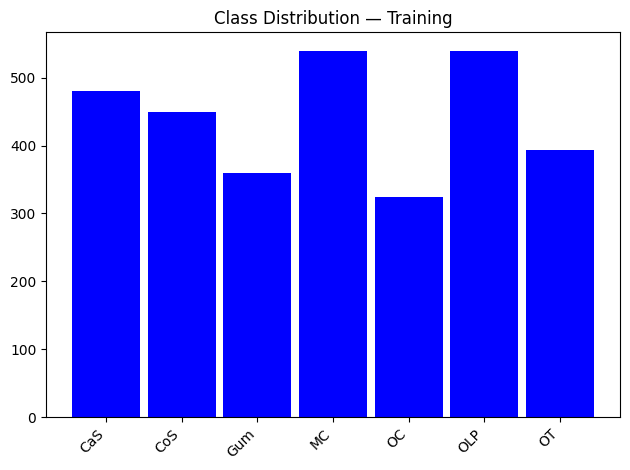

In [28]:
plot_class_distribution(train_dir, title="Training")

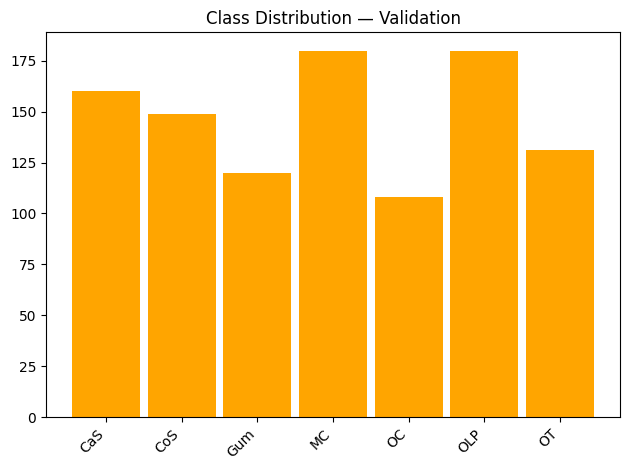

In [29]:
plot_class_distribution(val_dir, title="Validation")

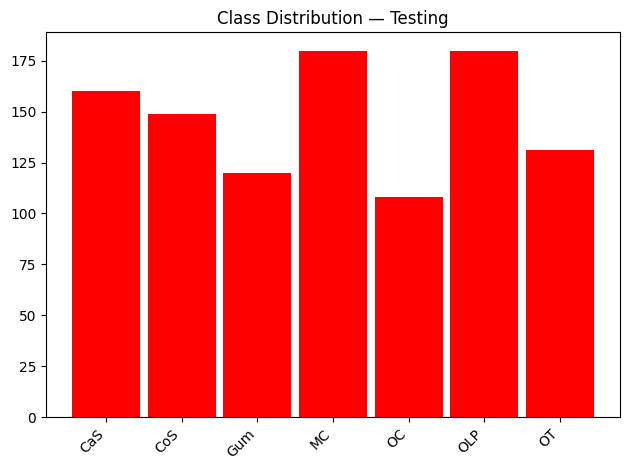

In [30]:
plot_class_distribution(test_dir, title="Testing")

In [31]:
## using seaborn
def plot_class_distribution_seaborn(dir_path: Path, title="Dataset"):
    counts = {}
    for cls_dir in sorted(dir_path.iterdir()):
        if cls_dir.is_dir():
            counts[cls_dir.name] = len(list(cls_dir.glob('*')))

    # **Create a pandas DataFrame for seaborn
    import pandas as pd
    df = pd.DataFrame({'Class': counts.keys(), 'Count': counts.values()})

    plt.figure(figsize=(10, 6)) # Adjust figure size as needed
    sns.barplot(x='Class', y='Count', data=df, color="blue", width=0.9)
    plt.title(f'Class Distribution — {title}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

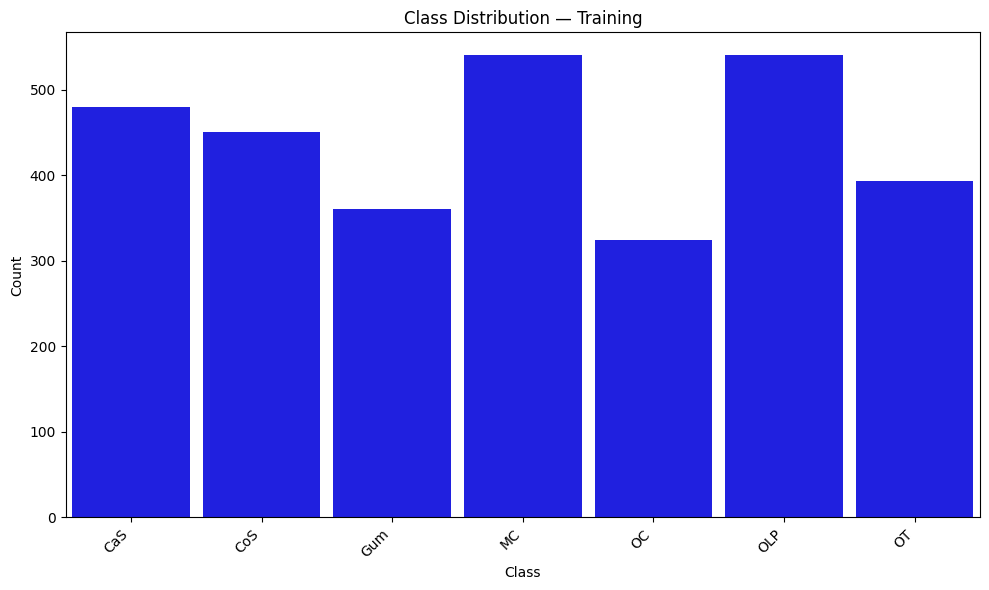

In [32]:
plot_class_distribution_seaborn(train_dir, title="Training")

In [33]:
def show_sample_images(dir_path: Path, title="Dataset", img_per_class=4, img_size=(128, 128)):
    import itertools
    img_paths = []
    classes = sorted([d.name for d in dir_path.iterdir() if d.is_dir()])
    for cls in classes:
        cls_dir = dir_path / cls
        samples = list(cls_dir.glob('*'))[:img_per_class]
        img_paths.extend(samples)
    cols = img_per_class
    rows = len(classes)
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i, p in enumerate(img_paths, 1):
        img = keras.utils.load_img(p, target_size=img_size)
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(p.parent.name, fontsize=8)
        plt.axis('off')
    plt.suptitle(f'Sample Images — {title}', y=1.02)
    plt.tight_layout()
    plt.show()


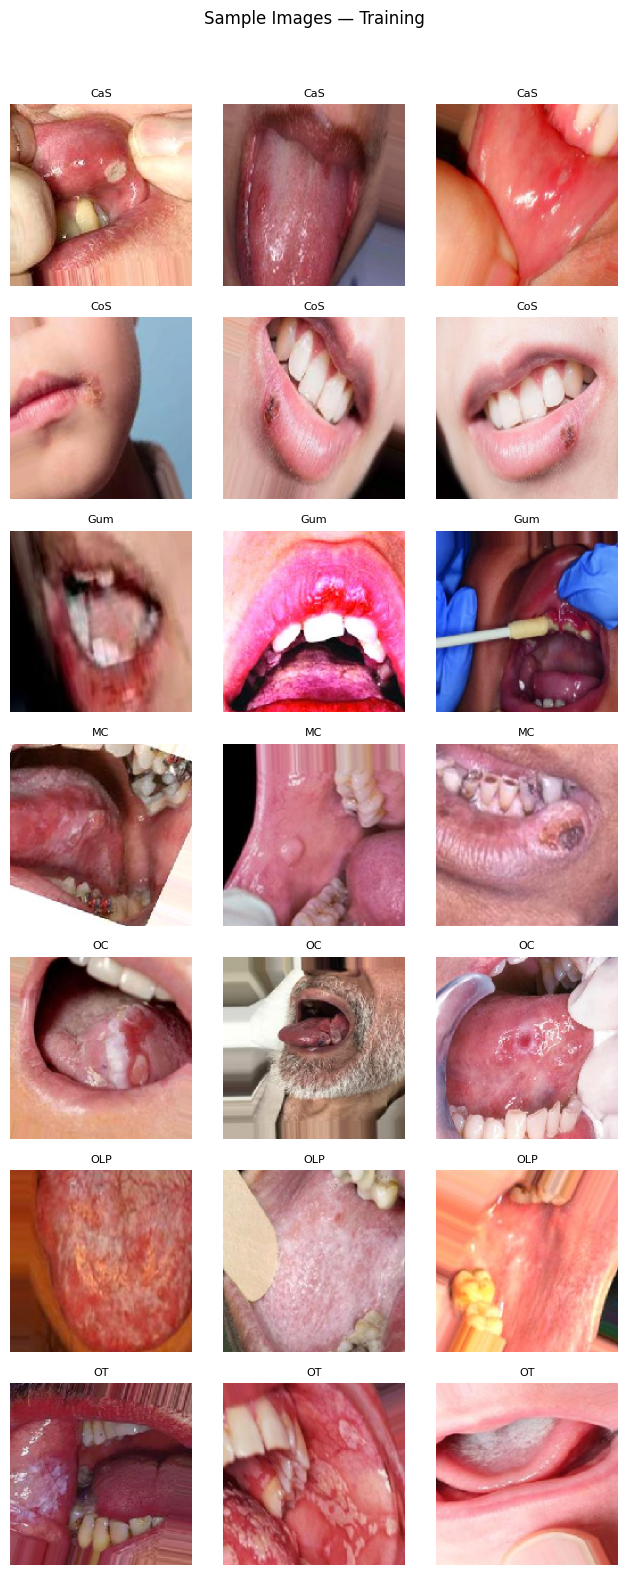

In [34]:
show_sample_images(train_dir,  title="Training", img_per_class=3, img_size=(160, 160))

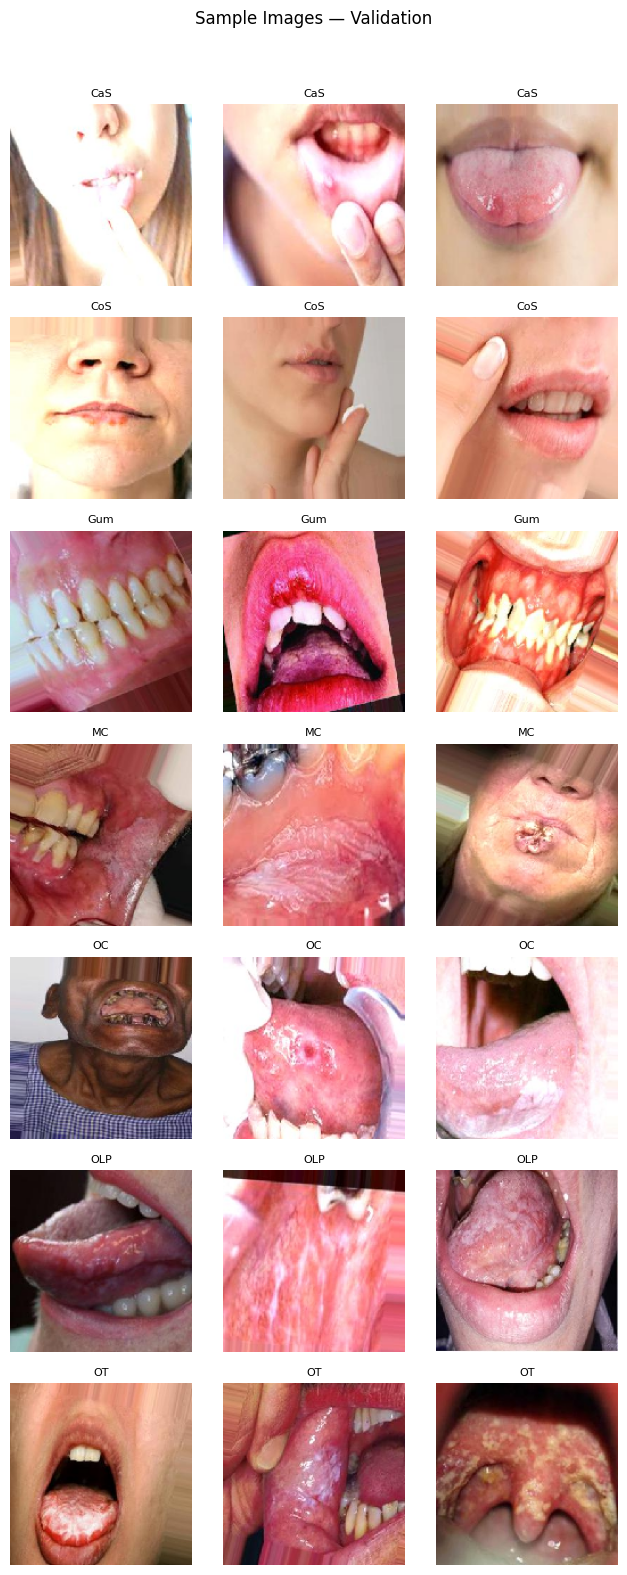

In [35]:
show_sample_images(val_dir, title="Validation", img_per_class=3, img_size=(160, 160))

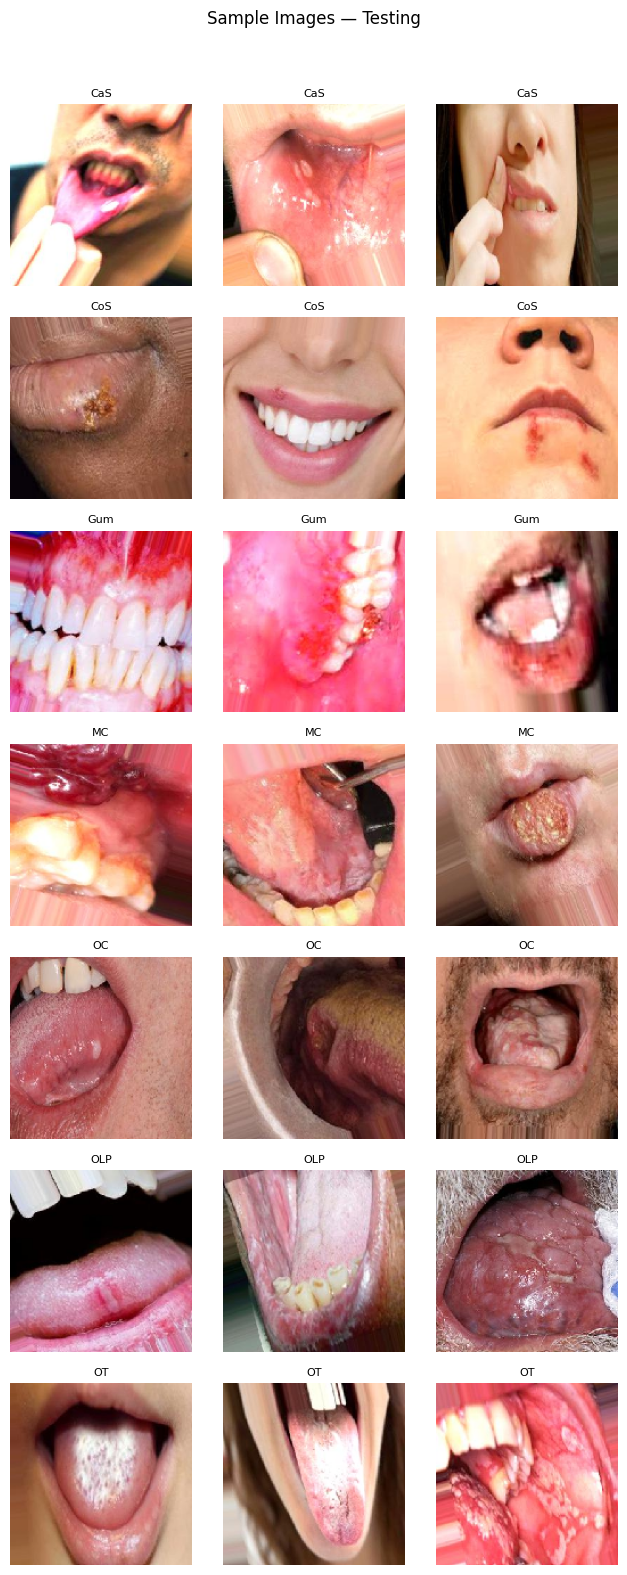

In [36]:
show_sample_images(test_dir, title="Testing", img_per_class=3, img_size=(160, 160))



---



# 5. Augmentation & Normalization

## For ALexNet and other Famous Image models, they work well with an input image of dimensions (224, 224, 3) (RGB)

In [37]:
# IMG_SIZE = (224, 224)
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    # label_mode='categorical',   ## One Hot Encoding
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 3087 files belonging to 7 classes.


This code snippet creates a tf.data.Dataset for your training data using tf.keras.preprocessing.image_dataset_from_directory.

* SPLIT_DIR / 'train': Specifies the directory containing your training images.

* labels='inferred': Tells the function to infer the class labels from the directory structure (each subdirectory within the SPLIT_DIR / 'train' is treated as a class).

* label_mode='int': Specifies that the labels should be returned as integers (0, 1, 2, ...).

* image_size=IMG_SIZE: Resizes all images to the dimensions specified by IMG_SIZE.

* batch_size=BATCH_SIZE: Groups the images into batches of size BATCH_SIZE.

* shuffle=True: Shuffles the data, which is important for training.

* seed=SEED: Sets a random seed for shuffling to ensure reproducibility.

This creates a train_ds object that you can use to feed data into your model during training.

you can select label_mode ="int" and use loss function -> "sparse_categorical_crossentropy"

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1028 files belonging to 7 classes.


In [40]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1028 files belonging to 7 classes.


In [41]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print('Classes:', class_names)

Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [42]:
# Prefetch & cache
def configure(ds, training=False):
    if training:
        ds = ds.shuffle(buffer_size=1000, seed=SEED)  # shuffles the dataset with a buffer size of 1000. Shuffling is important during training to prevent the model from learning the order of the data.
    return ds.prefetch(AUTOTUNE)

 applies the prefetch transformation to the dataset.

 prefetch overlaps the data preprocessing and model execution, allowing the next batch of data to be loaded while the current batch is being processed by the model.

 AUTOTUNE allows TensorFlow to automatically determine the optimal number of elements to prefetch.

In [43]:
from keras import layers

# Data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08)
    # layers.RandomTranslation(0.02, 0.02),
    # layers.RandomHeight(0.02),
    # layers.RandomWidth(0.02),
    # layers.Rescaling(1./255),
    # layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
], name='augmentation')

The selected code creates a Keras Sequential model named augmentation that applies data augmentation techniques to images. Data augmentation is used during training to artificially increase the size and diversity of the training dataset, which helps to improve the model's ability to generalize to unseen data and prevent overfitting.

* layers.RandomFlip("horizontal"): This layer randomly flips images horizontally.

* layers.RandomRotation(0.08): This layer randomly rotates images by a factor of 0.08. The rotation angle is within the range [-0.08 * 2PI, 0.08 * 2PI].

* layers.RandomZoom(0.08): This layer randomly zooms in or out on images by a factor of 0.08.

* layers.RandomContrast(0.08): This layer randomly adjusts the contrast of images by a factor of 0.08.


In [44]:
# # Normalization [0, 1]
# def normalize_img(img):
#   normalized_img = tf.cast(img, tf.float32) / 255.0

#   return normalized_img

This is a common normalization method, especially when the neural network layers expect input values in this range (e.g., when using activation functions like sigmoid).

In [45]:
# # Normalization to [-1, 1], sometimes better with gradient flow during training
def normalize_img(img): # preprocess(x)
    normalized_img = tf.cast(img, tf.float32) / 127.5 - 1.0

    return normalized_img

def normalize_img(img): # preprocess(x): This line defines the function normalize_img which is intended to take an image tensor img as input.

img = tf.cast(img, tf.float32) / 127.5 - 1.0: This line performs the normalization calculation. It casts the input tensor img to the float32 data type, divides the pixel values by 127.5, and then subtracts 1.0. This scales the original pixel values (typically in the range of 0-255) to the range of [-1, 1].

This range is often used when working with certain types of neural networks, such as those that utilize tanh activation functions or when using pre-trained models that were trained on data normalized to this range.

In [46]:
def preprocess_with(ds, training=False):
    return (ds
            .map(lambda x, y: (data_augmentation(x, training=training), y), num_parallel_calls=AUTOTUNE) if training else ds
           ).map(lambda x, y: (normalize_img(x), y), num_parallel_calls=AUTOTUNE)

* If training is True, it applies the data_augmentation layer to the images in the dataset using .map().
The num_parallel_calls=AUTOTUNE argument allows for parallel processing of the mapping operation for better performance.

* Regardless of the training flag, it then applies the preprocess function (which you defined earlier to normalize the images) to the images in the dataset using another .map() call, also with num_parallel_calls=AUTOTUNE.

In [47]:
train_ds_pp = configure(preprocess_with(train_ds, training=True), training=True)
val_ds_pp = configure(preprocess_with(val_ds, training=False), training=False) # training=False -> no augmentation in training.
test_ds_pp = configure(preprocess_with(test_ds, training=False), training=False)

The selected code applies the configure and preprocess_with functions to your training, validation, and test datasets.

For the train_ds, it calls preprocess_with with training=True to apply both augmentation and normalization, and then calls configure with training=True to apply shuffling and prefetching.

For the val_ds and test_ds, it calls preprocess_with with training=False to apply only normalization, and then calls configure with training=False to apply only prefetching.

This sets up the data pipelines for each dataset, ensuring that data is augmented and normalized for training, and only normalized and prefetched for evaluation and testing.

In [48]:
# Show augmented samples
def preview_exact_augment(ds, n=5):
    # Take one batch from the ORIGINAL dataset (not augmented)
    batch = next(iter(ds))
    imgs, labels = batch

    # Restrict to n images
    imgs = imgs[:n]
    labels = labels[:n]

    # Originals (from image_dataset_from_directory are already 0–255 uint8)
    originals = imgs.numpy().astype("uint8")

    # Apply augmentation manually (we pass imgs through augmentation only)
    aug_imgs = data_augmentation(imgs, training=True).numpy()
    aug_imgs = np.clip(aug_imgs, 0, 255).astype("uint8")

    # Plot originals vs augmented
    plt.figure(figsize=(10, 2*n))
    for i in range(n):
        # Original
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(originals[i])
        plt.title(f'Original: {class_names[labels[i].numpy()]}')
        plt.axis('off')

        # Augmented
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(aug_imgs[i])
        plt.title(f'Augmented: {class_names[labels[i].numpy()]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


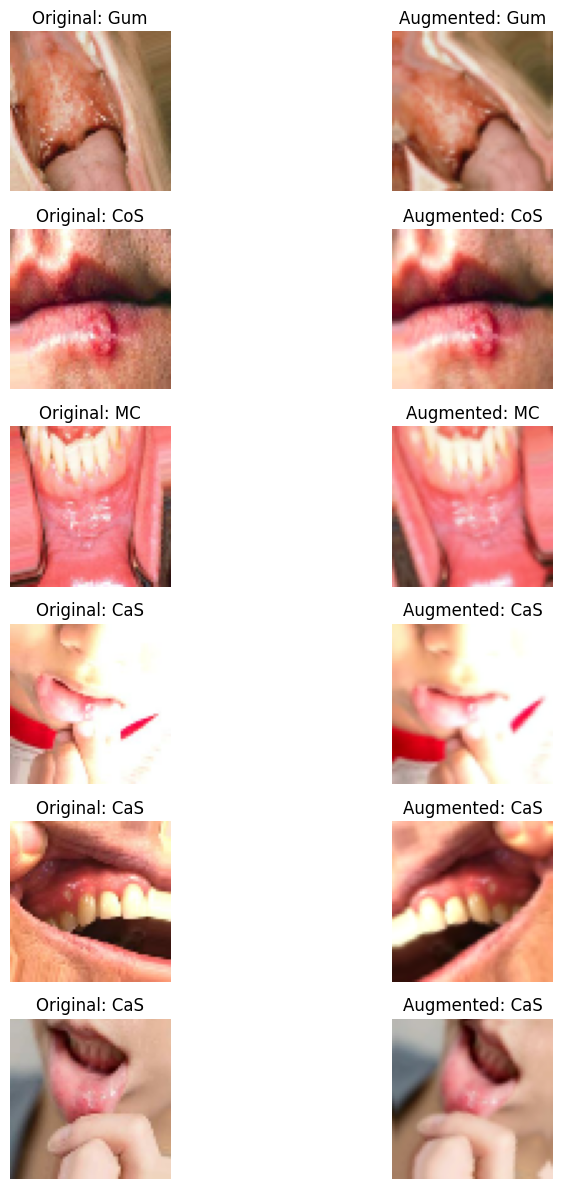

In [49]:
preview_exact_augment(train_ds, n=6)



---



# 6. Build CNN Model From Scratch

In [50]:
from tensorflow.keras.layers import BatchNormalization, Activation

In [56]:
def leNet_modified_model(input_shape, num_classes):
    model = Sequential()

    # Conv layers
    # model.add(Conv2D(input_shape=input_shape, filters=60, kernel_size=(5, 5), strides=1, activation="relu"))
    # model.add(Conv2D(filters=60, kernel_size=(5, 5), strides=1, activation="relu"))
    # model.add(Conv2D(filters=60, kernel_size=(5, 5), strides=1, activation="relu"))

    # Conv layers with Batch Normalization
    model.add(Conv2D(input_shape=input_shape, filters=60, kernel_size=(5, 5), strides=1))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(input_shape=input_shape, filters=60, kernel_size=(5, 5), strides=1))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(input_shape=input_shape, filters=60, kernel_size=(5, 5), strides=1))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # Pooling Layer
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # More Conv layers
    # model.add(Conv2D(filters=30, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(filters=30, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(filters=30, kernel_size=(3, 3), activation='relu'))


    # More Conv layers with Batch Normalization
    model.add(Conv2D(input_shape=input_shape, filters=30, kernel_size=(5, 5), strides=1))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(input_shape=input_shape, filters=30, kernel_size=(5, 5), strides=1))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(input_shape=input_shape, filters=30, kernel_size=(5, 5), strides=1))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # Pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    model.add(Dropout(rate=0.2)) # was 0.1

    # Flatten + Fully Connected Layers
    # model.add(Flatten())
    # model.add(Dense(units=500, activation="relu"))
    # model.add(Dropout(rate=0.4))
    # model.add(Dense(units=500, activation="relu"))
    # model.add(Dense(units=500, activation="relu"))

    # Flatten + Fully Connected Layers (Batch Normalization)
    model.add(Flatten())
    # first block
    model.add(Dense(units=500))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.2))          # was 0.4
    # second block
    model.add(Dense(units=500))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.2))           # didn't exist
    # third block
    model.add(Dense(units=500))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(rate=0.2))


    # Output layer
    model.add(Dense(units=num_classes, activation="softmax"))

    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [57]:
nn_model = leNet_modified_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES)

print(nn_model.summary() )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 60)     │         4,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 60, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 60, 60, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 56, 56, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 52, 52, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 52, 52, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 22, 22, 30)     │        45,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 22, 22, 30)     │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 22, 22, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 30)     │        22,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 18, 18, 30)     │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 18, 18, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 30)     │        22,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 14, 14, 30)     │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 14, 14, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1470)           │             

 Total params: 1,521,857 (5.81 MB)

 Trainable params: 1,518,317 (5.79 MB)

 Non-trainable params: 3,540 (13.83 KB)

None


# 7. Class Weights and Training

In [58]:
def compute_class_weights(train_dir: Path, class_names: List[str]) -> Dict[int, float]:
    counts = {i: len(list((train_dir / cls).glob('*'))) for i, cls in enumerate(class_names)}
    total = sum(counts.values())
    weights = {i: total / (len(class_names) * count) for i, count in counts.items() if count > 0}
    return weights

# Use your provided Training folder instead of SPLIT_DIR/'train'
class_weights = compute_class_weights(train_dir, class_names)
print('Class weights:', class_weights)

Class weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


The selected code defines a function compute_class_weights and then uses it to calculate class weights for your training data.

* def compute_class_weights(train_dir: Path, class_names: List[str]) -> Dict[int, float]:: This defines the function compute_class_weights that takes two arguments:

* * train_dir: A Path object
representing the directory containing the training data.
* * class_names: A list of strings representing the names of the classes.
* * The -> Dict[int, float] hint indicates that the function will return a dictionary with integer keys (representing class indices) and float values (representing the calculated weights).
* counts = {i: len(list((train_dir / cls).glob('*'))) for i, cls in enumerate(class_names)}: This line calculates the number of images in each class within the train_dir. It creates a dictionary where the keys are the class indices (obtained using enumerate) and the values are the counts of files (images) in each class subdirectory.
* total = sum(counts.values()): This calculates the total number of images across all classes.
* weights = {i: total / (len(class_names) * count) for i, count in counts.items() if count > 0}: This is the core of the class weight calculation. For each class with a count greater than 0, it calculates a weight using the formula: total number of images / (number of classes * number of images in the current class). This formula gives less weight to classes with more images and more weight to classes with fewer images, which can help address class imbalance during model training.
* return weights: The function returns the calculated dictionary of class weights.
* class_weights = compute_class_weights(train_dir, class_names): This line calls the compute_class_weights function with your train_dir and class_names to get the class weights for your dataset and stores them in the class_weights variable.
* print('Class weights:', class_weights): This line prints the calculated class weights.

These class weights can then be used during model training (e.g., in the model.fit() function) to give more importance to samples from underrepresented classes, potentially improving the model's performance on those classes.

In [55]:
## Loading the old model
from keras.models import load_model

# nn_model = load_model('/content/best_teeth_cnn.keras')

In [59]:
FIT_BATCH_SIZE = 300  # matches earlier pipeline
steps_per_epoch = len(train_ds) // FIT_BATCH_SIZE  # same idea as len(train_images_preprocessed) // batch_size

ckpt_path = str(DATA_ROOT / 'best_teeth_cnn.keras')
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    # keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
    ]

# Fit (similar look to your .fit_generator example)
nn_model_fit_augmentation = nn_model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    verbose=1,
    shuffle=True,
    # new parts added
    class_weight=class_weights,
    callbacks=callbacks
)

## relu 50 epochs
# Epoch 50: val_accuracy did not improve from 0.90078
# 97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9692 - loss: 0.0926 - val_accuracy: 0.8920 - val_loss: 0.3177 - learning_rate: 6.2500e-05
# Restoring model weights from the end of the best epoch: 50.

## elu 50 epochs another dropout layer and another fully connected layer
# Epoch 50: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
# 97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9665 - loss: 0.0973 - val_accuracy: 0.8473 - val_loss: 0.4631 - learning_rate: 6.2500e-05
# Restoring model weights from the end of the best epoch: 47.

## relu same layers as above (just added another FC layer (80) )
# Epoch 50: val_accuracy improved from 0.85603 to 0.86479, saving model to /content/best_teeth_cnn.keras
# 97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9086 - loss: 0.2513 - val_accuracy: 0.8648 - val_loss: 0.4371 - learning_rate: 1.2500e-04
# Restoring model weights from the end of the best epoch: 49.

## without batch normalization
# Epoch 43: val_accuracy improved from 0.87840 to 0.88035, saving model to /content/best_teeth_cnn.keras
# 97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9907 - loss: 0.0335 - val_accuracy: 0.8804 - val_loss: 0.4859 - learning_rate: 1.5625e-05

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2327 - loss: 2.1119
Epoch 1: val_accuracy improved from -inf to 0.25584, saving model to /content/best_teeth_cnn.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 140ms/step - accuracy: 0.2328 - loss: 2.1112 - val_accuracy: 0.2558 - val_loss: 1.9269 - learning_rate: 0.0010
Epoch 2/100
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3235 - loss: 1.7627
Epoch 2: val_accuracy improved from 0.25584 to 0.32782, saving model to /content/best_teeth_cnn.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.3238 - loss: 1.7619 - val_accuracy: 0.3278 - val_loss: 1.8218 - learning_rate: 0.0010
Epoch 3/100
95/97 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3889 - loss: 1.6052
Epoch 3: val_accuracy did not improve from 0.32782
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.3896 - loss: 1.6036 - val_accuracy: 0.2947 - val_loss: 1.8442 - learning_rate: 0.0010
Epoch 4/100
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4

The selected code sets up callbacks for training your neural network model. Callbacks are functions that can be applied at certain stages of the training process (e.g., at the end of each epoch).

1. keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1):
    * This callback saves the model's weights during training.
    * ckpt_path: Specifies the path where the best model will be saved.
    * monitor='val_accuracy': The callback will monitor the validation accuracy.
    * save_best_only=True: Only the model with the best validation accuracy seen so far will be saved.
    * mode='max': In this mode, the callback will look for the maximum value of the monitored metric (val_accuracy).
    * verbose=1: Prints messages when a better model is saved.
2. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1):
    * This callback reduces the learning rate when a metric has stopped improving.
    * monitor='val_loss': The callback will monitor the validation loss.
    * factor=0.5: The learning rate will be reduced by a factor of 0.5 (it will be halved).
    * patience=3: The learning rate will be reduced if the validation loss does not improve for 3 consecutive epochs.
    * verbose=1: Prints messages when the learning rate is reduced.
3. keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1):
    * This callback stops training when a monitored metric has stopped improving.
    * monitor='val_loss': The callback will monitor the validation loss.
    * patience=6: Training will stop if the validation loss does not improve for 6 consecutive epochs.
    * restore_best_weights=True: The model's weights will be restored to those from the epoch with the best value of the monitored metric (val_loss).
    * verbose=1: Prints messages when early stopping is triggered.

the model gets batches already augmented on the fly from train_ds_pp.
So augmentation is built into the pipeline — you don’t need to explicitly call .flow() like in your older fit_generator style.



---



# 8. Training Curves & Evaluation

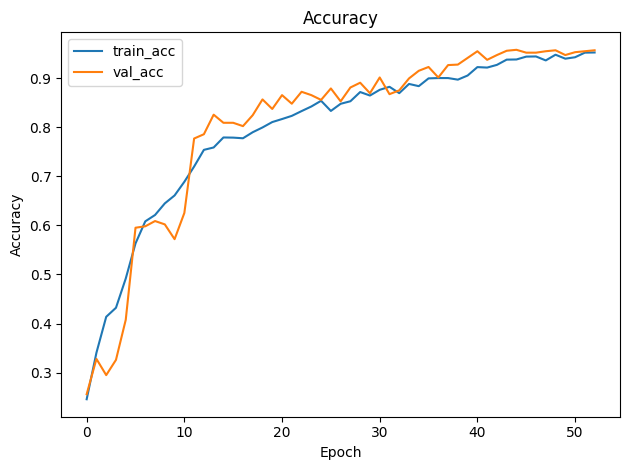

In [60]:
def plot_accuracy_curves(model):
    plt.figure()
    plt.plot(model.history['accuracy'], label='train_acc')
    plt.plot(model.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_accuracy_curves(nn_model_fit_augmentation)

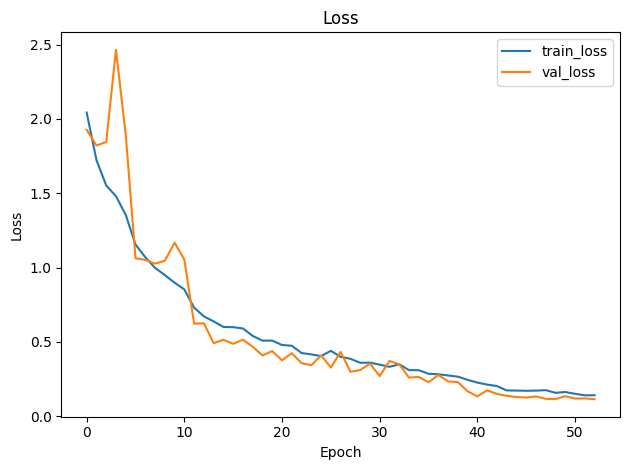

In [61]:
def plot_losses_curves(model):
    plt.figure()
    plt.plot(model.history['loss'], label='train_loss')
    plt.plot(model.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_losses_curves(nn_model_fit_augmentation)

In [67]:
# Evaluate on test set
test_loss, test_acc = nn_model.evaluate(test_ds_pp, verbose=0)
print(f'Test — loss: {test_loss:.4f}, accuracy: {test_acc * 100:.3f}%')

Test — loss: 0.1629, accuracy: 94.261%


In [68]:
# Confusion matrix & classification report
y_true = []
y_pred = []
for imgs, labels in test_ds_pp:
    preds = nn_model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

In [69]:
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\\n', cm)

Confusion Matrix:\n [[150   3   1   1   2   2   1]
 [  1 148   0   0   0   0   0]
 [  1   0 113   0   2   3   1]
 [  2   2   1 160   4   7   4]
 [  0   0   1   1 104   2   0]
 [  0   1   1   4   2 168   4]
 [  0   0   0   3   2   0 126]]


In [70]:
print('\\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

\nClassification Report:
              precision    recall  f1-score   support

         CaS       0.97      0.94      0.96       160
         CoS       0.96      0.99      0.98       149
         Gum       0.97      0.94      0.95       120
          MC       0.95      0.89      0.92       180
          OC       0.90      0.96      0.93       108
         OLP       0.92      0.93      0.93       180
          OT       0.93      0.96      0.94       131

    accuracy                           0.94      1028
   macro avg       0.94      0.95      0.94      1028
weighted avg       0.94      0.94      0.94      1028



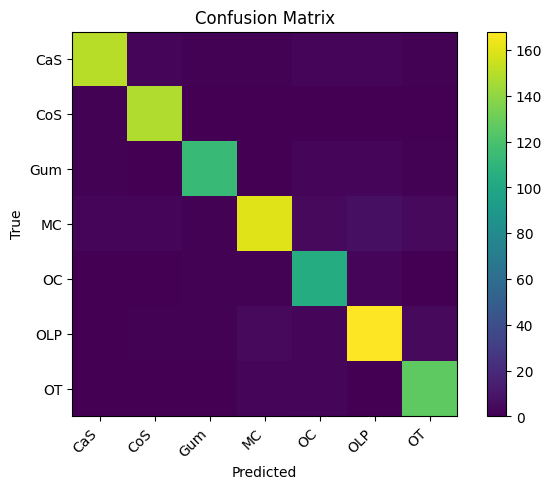

In [72]:
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

* The plot itself: It's a grid (or matrix) that shows how well your classification model performed on the test set.
* Rows: Each row represents the actual class of the images (the "True" labels).
* Columns: Each column represents the predicted class by your model.
* Cells: The numbers in each cell indicate the count of images that belong to the true class of that row and were predicted as the class of that column.
* * Diagonal cells (top-left to bottom-right): These numbers represent the correct classifications. For example, the number in the top-left cell is the count of images that were actually 'CaS' and were correctly predicted as 'CaS'.
* Off-diagonal cells: These numbers represent the incorrect classifications (errors). For example, the number in the first row, second column shows how many images were actually 'CaS' but were incorrectly predicted as 'CoS'.

In [ ]:
# nn_model_score = nn_model.evaluate(test_ds_pp, verbose=0)

# print("Test score: ", nn_model_score[0] * 100)
# print("Test accuracy: ", nn_model_score[1] * 100 , "%")



---



### Saving the Model

In [73]:
# // creates a HDF5 file nn_model.save('my_model.h5')  # / the hdf5 is wrong(old way)

# // creates a keras file (new way of saving)
nn_model.save('Teeth classification- LeNet modified model.keras')

# // deletes the existing model
# del nn_model

# // returns a compiled model
from keras.models import load_model

# nn_model = load_model('12.5.CNN_model_traffic_signs_augmented.keras')



---

